## Improving Quantum Circuit performance with TKET on H-Series devices and other platforms

#### Estimating Two-Qubit Gater Error

$ \% \text{Error}_{2QG} = (1-\text{Fidelity}^N) \times 100\% $

where $N$ i the number of two qubit gates in system.

Examples:

$100$ 2QGs with the fidelity of $0.993$, which means the error% of $=(1-0.993^{100}) \times 100\% = 50\%$

$100$ 2QGs with the fidelity of $0.998$, which means the error% of $=(1-0.998^{100}) \times 100\% = 18\%$

$100$ 2QGs with the fidelity of $0.998$, which means the error% of $=(1-0.999^{100}) \times 100\% = 9.5\%$



![alt text](img.png "2 Qubit Gate Fidelity")

## TKET Extensions

![alt text](img2.png "Title")

## TKET has a default pass manager for each backend

`get_compiled_circuit(circuit,optimization_level)`

![alt text](img3.png "Title")

In [1]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-1'

backend = QuantinuumBackend(device_name = machine)
backend.login()

In [2]:
print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1 status:  reserved


In [3]:
[x.device_name for x in QuantinuumBackend.available_devices()]

['H1-1SC', 'H1-1E', 'H1-1']

## Importing a Circuit from QIskit

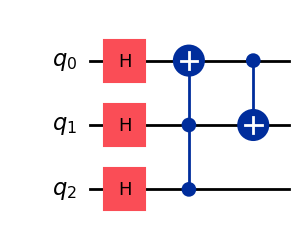

In [4]:
from qiskit import QuantumCircuit

qiskit_circuit = QuantumCircuit(3)
qiskit_circuit.h(range(3))
qiskit_circuit.ccx(2,1,0)
qiskit_circuit.cx(0,1)
qiskit_circuit.draw(output='mpl',style='iqx')

In [5]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter # necessary to visualize circuits in Jupyter
tket_circ = qiskit_to_tk(qiskit_circuit)    
render_circuit_jupyter(tket_circ)

### Using Backends

In [6]:
from pytket import Circuit

ghz_circ = Circuit(3)
ghz_circ.H(0)
ghz_circ.CX(0, 1)
ghz_circ.CX(1, 2)
ghz_circ.add_barrier(ghz_circ.qubits)
ghz_circ.measure_all()
render_circuit_jupyter(ghz_circ)

### Running on qiskit simulator

In [7]:


from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
result = backend.run_circuit(ghz_circ)
print(result.get_counts())



Counter({(1, 1, 1): 520, (0, 0, 0): 504})


In [8]:
from qiskit.visualization import plot_histogram

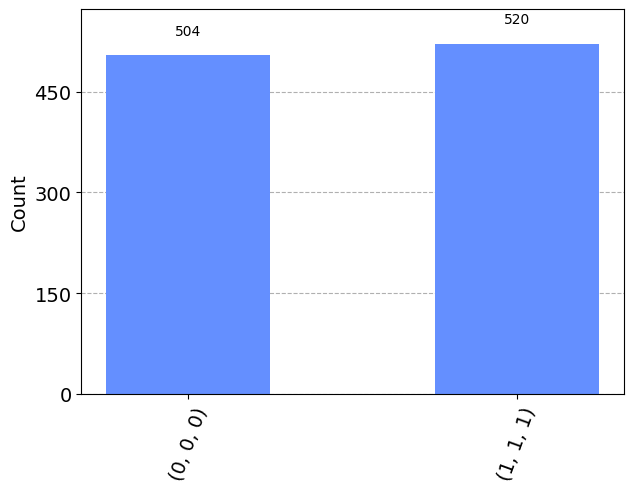

In [9]:
plot_histogram(result.get_counts())

#### Running on Quantinuum Simulator

In [10]:
machine = 'H1-1E'

backend = QuantinuumBackend(device_name = machine)

print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1E status:  online


Well there's no need to compile it, but we'll do it anyways

In [11]:
compiled_circ = backend.get_compiled_circuit(ghz_circ,optimisation_level=2)
render_circuit_jupyter(compiled_circ)

Let's see how much will it cost to run on actual quantum hardware

In [12]:
n_shots = 100
backend.cost(compiled_circ, n_shots=n_shots, syntax_checker='H1-1E')

6.1

Let's run it on Simulator

In [13]:
handle = backend.process_circuit(compiled_circ, n_shots=n_shots)

print(handle)

status = backend.circuit_status(handle)
print(status)

('558cc6d149614d4480ae93966ed7ca5a', 'null', 3, '[["c", 0], ["c", 1], ["c", 2]]')
CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "job", "submit-date": "2023-12-20T06:26:01.149239", "result-date": null, "queue-position": null, "cost": "6.1", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [14]:
result = backend.get_result(handle)
print(result.get_counts())

Counter({(1, 1, 1): 50, (0, 0, 0): 49, (1, 0, 0): 1})


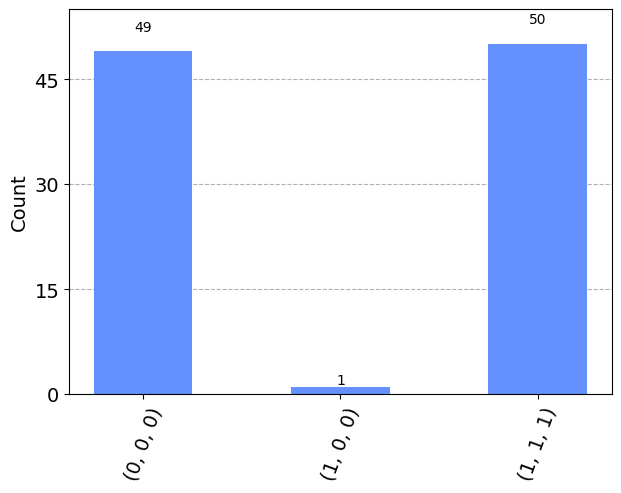

In [15]:
plot_histogram(result.get_counts())

### This is how you save the result in quantinuum

In [16]:
import json
with open('ghz.json', 'w') as f:
    json.dump(result.to_dict(), f)

In [17]:
from pytket.backends.backendresult import BackendResult

with open('ghz.json', 'r') as f:
    data = json.load(f)

result = BackendResult.from_dict(data)

In [18]:
result = backend.get_result(handle)
print(result.get_counts())
print(result.get_distribution())


Counter({(1, 1, 1): 50, (0, 0, 0): 49, (1, 0, 0): 1})
{(0, 0, 0): 0.49, (1, 0, 0): 0.01, (1, 1, 1): 0.5}


## More such comparisons

Let's compare the number of gates that are reduced by IBM qiskit and Quantinuum tket, by using a circuit that is important to us

#### Making the circuit in qiskit

In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt



from qiskit import *                    # getting all the necessary qiskit packages

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.visualization import *      # visualization tools
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import IntegerComparator,TwoLocal
from qiskit.circuit.library.arithmetic import LinearAmplitudeFunction, CDKMRippleCarryAdder
from qiskit.circuit.library import RealAmplitudes

simulator = BasicAer.get_backend('qasm_simulator')  # setting the backend
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_algorithms.optimizers import optimizer, ADAM,GradientDescent, SPSA, COBYLA, GSLS, SLSQP, AQGD, NELDER_MEAD, POWELL


from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import RYGate
from qiskit_aer.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit_aer.primitives import Sampler
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import IntegerComparator
from qiskit.circuit.library import MCMT
from qiskit.circuit.library import OR

In [20]:
def risk_model(params):
    '''
    args: params: the parameters of the circuit
    returns: the value of the objective function

    the objective function is the expected profit of the newsvendor problem
    the parameters are the rotation angles for the circuit for both the suppliers

    '''

    mu = 10      # the mean of the demand
    sigma = 0.5 # the standard deviation of the demand
    c = 0.01     # the approximation constant for the equation sin^2(c*f(x,y)+ pi/2) = c*f(x,y) + 1/2 
    p = 1        # price of selling the product

    c1 = 0.75    # cost of buying the product from supplier 1
    c2 = 0.551   # cost of buying the product from supplier 2
    '''
    Since we are only dealing with two suppliers, we have only two costs, 
    later experiments might consider more suppliers, whilst reducing their capacity from 0-15 to 0-7

    '''
    #c3 = 0.73   # cost of buying the product from supplier 3
    #c4 = 0.2    # cost of buying the product from supplier 4


    o = 0.9     # the unit shortage cost
    w = 0.2      # the unit salvage value
    f1 = 0.5     # fixed cost of buying from supplier 1
    f2 = 0.4     # fixed cost of buying from supplier 2
    #f3 = 0.5    # fixed cost of buying from supplier 3
    #f4 = 0.5    # fixed cost of buying from supplier 4
    
    '''
    The reliability of the suppliers is given by the following variables, they can either be fixed(as done currently) or 
    can be made random normal variables with a given mean and variance. But that hurts the optimization process, so we are
    keeping them fixed for now.
    '''
    R1 = 0.2441414141414141
    R2 = 0.543619319883221


    '''
    Doing subtraction first, that reduces the number of multiplication operations required, as multiplication is costlier
    '''
    a = p-w
    x1 = w-c1
    x2 = w-c2
    b = o-w

    ## Demand
    demand = NormalDistribution(num_qubits=4,mu=mu,sigma=sigma,  bounds=[0,15])

    ## supplier 1
    supply1 = RealAmplitudes(4, reps=2) 

    '''
    params is a list of 24 values, the first 12 are the parameters for supplier 1 and the next 12 are for supplier 2
    '''
    supply1 = supply1.assign_parameters(params[:12])

    ## supplier 2
    supply2 = RealAmplitudes(4, reps=2)
    
    supply2 = supply2.assign_parameters(params[12:])



    '''
    Making of the quantum circuit, take an empty 20 qubits circuit, and add the demand, supplier 1 and supplier 2 circuits, and then
    rotate all the functions values , step by step

    '''    
    qc = QuantumCircuit(20)
    qc.compose(demand,qubits=[8,9,10,11], inplace=True)     # loading the demand circuit
    qc.compose(supply1, qubits = [0,1,2,3], inplace=True)   # loading the supplier 1 circuit
    qc.compose(supply2, qubits = [4,5,6,7], inplace=True)   # loading the supplier 2 circuit

    # loading the (p-w)D circuit, where (p-w) = a

    for i in range(8,12):
        qc.cry(2*c*a*(2**(i-8)),i,17)
    qc.barrier()

    # loading the (w-ci)Ri qi onto the circuit where (w-ci) = xi


    for i in range(0,4):
        qc.cry(2*c*x1*R1*(2**(i)),i,17)
    qc.barrier()
    for i in range(4,8):
        qc.cry(2*c*x2*R2*(2**(i-4)),i,17)
    qc.barrier()


    # adding the fixed cost of -f1 and -f2

    qc.compose(OR(4), qubits=[0,1,2,3,12], inplace=True)
    qc.compose(OR(4), qubits=[4,5,6,7,13], inplace=True)

    qc.cry(-2*c*f1,12,17)
    qc.cry(-2*c*f2,13,17)


    '''
    Till this point, the objective function that we have loaded onto the quantum circuit is the following:

    f = (p-w)D + (w-c1)R1q1 + (w-c2)R2q2 - f1 x1 - f2 x2

    The next operation will be done based on the comparison of q1+q2 with demand D, for that first we'll need to
    add q1 and q2 , then compare it with D, store the result in a new qubit, and then do the subtraction of q2-(q1+q2),
    to get back our q1 and then rotate the value of the function , to give our function it's final form.
    '''

    
    # addition of q1 and q2 , using the addition operation of ripple carry adder, it does the in-place addition of q1 and q2, and
    # the result is stored in q1
    qc.barrier()

    for i in range(1,3):
        qc.cx(14,i)
    for i in range(5,8):
        qc.cx(14,i)
    qc.ccx(0,4,14)
    qc.x(4)

    qc.cx(14,5)
    qc.cx(14,1)
    qc.ccx(1,5,14)
    qc.ccx(5,1,0)

    qc.cx(14,6)
    qc.cx(14,2)
    qc.ccx(2,6,14)
    qc.ccx(6,2,0)

    qc.cx(14,7)
    qc.cx(14,3)
    qc.ccx(3,7,14)

    qc.cx(0,7)
    qc.ccx(6,2,0)

    qc.cx(0,6)
    qc.ccx(5,1,0)

    qc.ccx(0,4,7)
    qc.ccx(0,4,6)
    qc.x(4)
    qc.ccx(0,4,5)

    qc.cx(4,0)
    qc.cx(5,1)
    qc.cx(6,2)
    qc.cx(7,3)




    # comparison of q1+q2 with D, and storing the result in q16, which will be in |1> state if q1+q2 <= D, else in |0> state

    qc.barrier()
    for i in range(8,12):
        qc.x(i)

    qc.x(15)

    for i in range(1,4):
        qc.cx(16,i)
    qc.cx(16,14)

    for i in range(9,12):
        qc.cx(16,i)
    qc.cx(16,15)

    qc.ccx(0,8,16)
    qc.x(8)

    qc.cx(16,9)
    qc.cx(16,1)
    qc.ccx(1,9,16)
    qc.ccx(9,1,0)

    qc.cx(16,10)
    qc.cx(16,2)
    qc.ccx(2,10,16)
    qc.ccx(10,2,0)

    qc.cx(16,11)
    qc.cx(16,3)
    qc.ccx(3,11,16)
    qc.ccx(11,3,0)

    qc.cx(16,15)
    qc.cx(16,14)
    qc.ccx(14,15,16)


    qc.cx(0,15)
    qc.cx(0,14)
    qc.ccx(11,3,0)

    qc.cx(0,11)
    qc.cx(0,3)
    qc.ccx(10,2,0)

    qc.cx(0,10)
    qc.cx(0,2)
    qc.ccx(9,1,0)

    qc.ccx(0,8,15)
    qc.ccx(0,8,14)
    qc.ccx(0,8,11)
    qc.ccx(0,8,3)
    qc.ccx(0,8,10)
    qc.ccx(0,8,2)

    qc.x(8)
    qc.ccx(0,8,9)
    qc.ccx(0,8,1)
    qc.x(8)

    for i in range(8,13):
        qc.x(i)
    qc.x(15)
    qc.x(16)



    # subtraction of q2-(q1+q2), to get back q1, and then rotating the value of the function, the q1 value is then rewritten on it's original qubits

    qc.barrier()

    for i in range(4,8):
        qc.x(i)
    qc.x(18)

    for i in range(1,4):
        qc.cx(19,i)
    qc.cx(19,14)

    for i in range(5,8):
        qc.cx(19,i)
    qc.cx(19,18)

    qc.ccx(0,4,19)
    qc.x(4)

    qc.cx(19,5)
    qc.cx(19,1)
    qc.ccx(1,5,19)
    qc.ccx(5,1,0)

    qc.cx(19,6)
    qc.cx(19,2)
    qc.ccx(2,6,19)
    qc.ccx(6,2,0)

    qc.cx(19,7)
    qc.cx(19,3)
    qc.ccx(3,7,19)
    qc.ccx(7,3,0)

    qc.cx(19,18)
    qc.cx(19,14)
    qc.ccx(14,18,19)

    qc.cx(0,18)
    qc.ccx(7,3,0)

    qc.cx(0,7)
    qc.ccx(6,2,0)

    qc.cx(0,6)
    qc.ccx(5,1,0)

    qc.ccx(0,4,18)
    qc.ccx(0,4,7)
    qc.ccx(0,4,6)
    qc.x(4)
    qc.ccx(0,4,5)

    qc.cx(4,0)
    qc.cx(5,1)
    qc.cx(6,2)
    qc.cx(7,3)
    qc.cx(18,14)

    qc.x(0)
    qc.x(4)
    qc.x(5)
    qc.x(6)
    qc.x(7)
    qc.x(18)
    qc.x(19)
    qc.x(1)
    qc.x(2)
    qc.x(3)
    qc.x(14)


    
    # loading second part of the function

    qc.barrier()

    # loading -(o-w)D onto the circuit, where (o-w) = b

    for i in range(8,12):
        c2ry = RYGate(-2*c*b* 2**(i-8)).control(2)
        qc.append(c2ry,[i,16,17])

    
    # loading the (o-w)Ri qi onto the circuit where (o-w) = b
    for i in range(0,4):
        c2ry = RYGate(2*c*b*R1*2**(i)).control(2)
        qc.append(c2ry,[i,16,17])


    for i in range(4,8):
        c2ry = RYGate(2*c*b*R2*2**(i-4)).control(2)
        qc.append(c2ry,[i,16,17])


    '''
    At this point, the objective function is complete, and it is in the following form:

    f = (p-w)D + (w-c1)R1q1 + (w-c2)R2q2 - f1 x1 - f2 x2 - (o-w)D + (o-w)R1q1 + (o-w)R2q2
    '''

    









    # this is very important step, don't forget to add this, it is the final rotation of the function value, to get the final form of the function
    qc.ry(np.pi/2,17)
    



    #epsilon = 0.01   # the error tolerance
    #alpha = 0.5      # the alpha value or the confidence level


    #problem = EstimationProblem(state_preparation=qc,objective_qubits=[17])     # make the estimation problem which can be read by IAE

    # # construct amplitude estimation and run the algorithm
    # iae = IterativeAmplitudeEstimation(
    #     epsilon_target=epsilon,
    #     alpha=alpha,
    #     sampler=Sampler(run_options={"shots": 2000})
    # )

    # result = iae.estimate(problem)      # check the result of the estimation
    # #return result.estimation
    # return -((result.estimation-0.5)/c)  # do the final pre-processing, and a minus sign is added because we are doing maximization

    return qc
        

In [ ]:
params = [np.pi/2]*24     # initial parameters for the circuit
risk_model(params).draw(output='mpl',style='iqx',fold=-1)

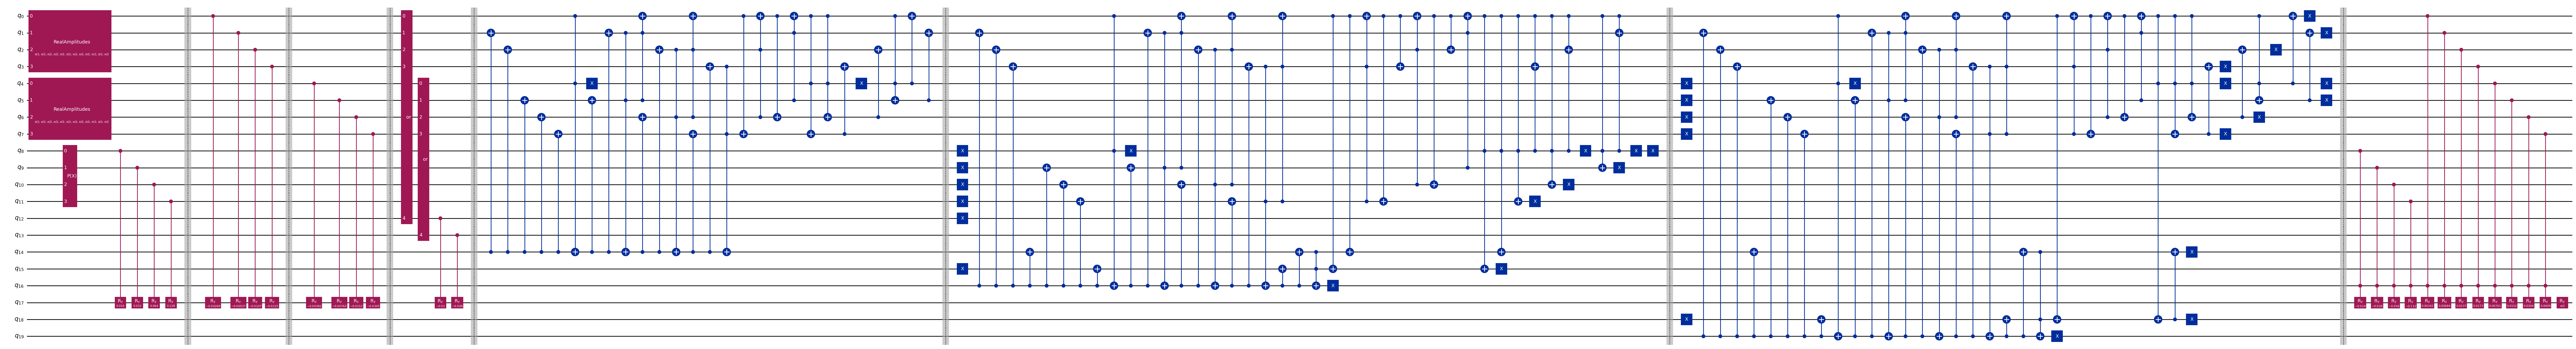

In [22]:
qiskit_circuit = risk_model(params)
qiskit_circuit.draw(output='mpl',style='iqx',fold=-1)

Let's decompose the circuit first:

In [23]:
# let's select a qiskit backend
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()


In [24]:
service.backends()

[<IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibm_algiers')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibmq_mumbai')>]

In [37]:
backend = service.least_busy(simulator=False,operational=True, min_num_qubits=5)

In [38]:
print(backend)

<IBMBackend('ibm_osaka')>


## Optimization Level 0

In [40]:
from qiskit import transpile


qiskit_circuit_decomposed_0 = transpile(qiskit_circuit, backend=backend)

#qiskit_circuit_decomposed.draw(output='mpl',style='iqx',fold=-1)

In [42]:
print('Original depth:', qiskit_circuit.depth(), 'Decomposed Depth:', qiskit_circuit_decomposed_0.depth())

Original depth: 128 Decomposed Depth: 4605


In [43]:
print(qiskit_circuit_decomposed_0.num_qubits)

127


In [44]:
print(dict(qiskit_circuit_decomposed_0.count_ops()))

{'rz': 4798, 'sx': 3541, 'ecr': 1818, 'x': 379, 'barrier': 7}


Here `ECR` is the two qubit gate, and the rest are single qubit gates

Let's make a `tket` circuit out of it

In [45]:
from pytket.extensions.qiskit import qiskit_to_tk

tket_circ = qiskit_to_tk(qiskit_circuit_decomposed_0)
#render_circuit_jupyter(tket_circ)

In [46]:
print("total number of gates:",tket_circ.n_gates)    

print("number of qubits:",tket_circ.n_qubits)

print("number of bits:",tket_circ.n_bits)

print("number of two qubit gates: ", tket_circ.n_2qb_gates())



total number of gates: 10543
number of qubits: 127
number of bits: 0
number of two qubit gates:  1818


In [47]:
print("Number of two qubit gates in qiskit are: ", dict(qiskit_circuit_decomposed.count_ops())['ecr'], " \n and the number of two qubit gates in tket are: ", tket_circ.n_2qb_gates())


Number of two qubit gates in qiskit are:  1818  
 and the number of two qubit gates in tket are:  1818


Let's see how many gates do we have in `tket`

In [70]:
machine = 'H1-1'

backend_qt = QuantinuumBackend(device_name = machine)

print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1 status:  reserved


In [71]:
tket_circ_0 = backend_qt.get_compiled_circuit(tket_circ,optimisation_level=0)


In [72]:
print("total number of gates:",tket_circ_0.n_gates)    

print("number of qubits:",tket_circ_0.n_qubits)

print("number of bits:",tket_circ_0.n_bits)

print("number of two qubit gates: ", tket_circ_0.n_2qb_gates())



total number of gates: 19633
number of qubits: 26
number of bits: 0
number of two qubit gates:  1818


In [73]:
print("Number of two qubit gates in qiskit are: ", dict(qiskit_circuit_decomposed_0.count_ops())['ecr'], " \n and the number of two qubit gates in tket are: ", tket_circ_0.n_2qb_gates())


Number of two qubit gates in qiskit are:  1818  
 and the number of two qubit gates in tket are:  1818


### Optimization Level 1

In [74]:
from qiskit import transpile


qiskit_circuit_decomposed_1 = transpile(qiskit_circuit, backend=backend,optimization_level=1)
print('Original depth:', qiskit_circuit.depth(), 'Decomposed Depth:', qiskit_circuit_decomposed_1.depth())
#qiskit_circuit_decomposed.draw(output='mpl',style='iqx',fold=-1)

Original depth: 128 Decomposed Depth: 4618


In [75]:
print(dict(qiskit_circuit_decomposed_1.count_ops()))

{'rz': 4844, 'sx': 3576, 'ecr': 1848, 'x': 376, 'barrier': 7}


Now TKET

In [76]:
tket_circ_1 = backend_qt.get_compiled_circuit(tket_circ,optimisation_level=1)

print("total number of gates:",tket_circ_1.n_gates)    

print("number of qubits:",tket_circ_1.n_qubits)

print("number of bits:",tket_circ_1.n_bits)

print("number of two qubit gates: ", tket_circ_1.n_2qb_gates())



total number of gates: 4825
number of qubits: 26
number of bits: 0
number of two qubit gates:  1818


In [77]:
print("Number of two qubit gates in qiskit are: ", dict(qiskit_circuit_decomposed_1.count_ops())['ecr'], " \n and the number of two qubit gates in tket are: ", tket_circ_1.n_2qb_gates())


Number of two qubit gates in qiskit are:  1848  
 and the number of two qubit gates in tket are:  1818


### Optimization Level 2

In [78]:
from qiskit import transpile


qiskit_circuit_decomposed_2 = transpile(qiskit_circuit, backend=backend,optimization_level=2)
print('Original depth:', qiskit_circuit.depth(), 'Decomposed Depth:', qiskit_circuit_decomposed_2.depth())
#qiskit_circuit_decomposed.draw(output='mpl',style='iqx',fold=-1)

Original depth: 128 Decomposed Depth: 4573


In [79]:
print(dict(qiskit_circuit_decomposed_2.count_ops()))

{'rz': 4531, 'sx': 3401, 'ecr': 1734, 'x': 364, 'barrier': 7}


Same with TKET

In [92]:
tket_circ_2 = backend_qt.get_compiled_circuit(tket_circ,optimisation_level=2)

print("total number of gates:",tket_circ_2.n_gates)    

print("number of qubits:",tket_circ_2.n_qubits)

print("number of bits:",tket_circ_2.n_bits)

print("number of two qubit gates: ", tket_circ_2.n_2qb_gates())



total number of gates: 1284
number of qubits: 26
number of bits: 0
number of two qubit gates:  485


In [81]:
print("Number of two qubit gates in qiskit are: ", dict(qiskit_circuit_decomposed_2.count_ops())['ecr'], " \n and the number of two qubit gates in tket are: ", tket_circ_2.n_2qb_gates())


Number of two qubit gates in qiskit are:  1734  
 and the number of two qubit gates in tket are:  485


Although IBM supports optimization level 3, TKET only offers upto level 2

### Optimization Level 3

In [82]:
from qiskit import transpile


qiskit_circuit_decomposed_3 = transpile(qiskit_circuit, backend=backend,optimization_level=3)
print('Original depth:', qiskit_circuit.depth(), 'Decomposed Depth:', qiskit_circuit_decomposed_3.depth())
#qiskit_circuit_decomposed.draw(output='mpl',style='iqx',fold=-1)

Original depth: 128 Decomposed Depth: 5449


In [83]:
print(dict(qiskit_circuit_decomposed_3.count_ops()))

{'rz': 6050, 'sx': 4331, 'ecr': 1612, 'x': 362, 'barrier': 7}


In [84]:
print("Number of two qubit gates in qiskit are: ", dict(qiskit_circuit_decomposed_3.count_ops())['ecr'], " \n and the number of two qubit gates in tket are: ", tket_circ_2.n_2qb_gates())


Number of two qubit gates in qiskit are:  1612  
 and the number of two qubit gates in tket are:  485


Although `tket` doesn't have an `optimization_level=3`, we will be using the second optimization level to compare with the third optimization level of qiskit. 

#### Total Number of gates for different levels of Optimization

![alt text](plot1.png "Comaparison")

### Total number of two qubit gates for levels of optimization

![alt text](plot2.png "Comaparison")

Given the fully-connected architecture of `Quantinuum`, it's evident that we need less number of two qubit gates, where most of these are the `SWAP` gates.

Let's convert the best `tket` circuit to `qiskit`

In [93]:
from pytket.extensions.qiskit import tk_to_qiskit

qiskit_circ_final = tk_to_qiskit(tket_circ_2)
print(qiskit_circ_final)

global phase: 6.0868
                                                                   »
 q_0: ─────────────────────────────────────────────────────────────»
                                                                   »
 q_1: ─────────────────────────────────────────────────────────────»
                                                                   »
 q_2: ─────────────────────────────────────────────────────────────»
       ┌───────────────┐                                           »
 q_3: ─┤ R(2.8985,π/2) ├──────────────────────────────────■────────»
      ┌┴───────────────┴─┐                 ┌────────┐     │        »
 q_4: ┤ R(0.016695,3π/2) ├─■───────────────┤ R(π,π) ├─────┼────────»
      └──┬───────────┬───┘ │ZZ(1.4686) ┌───┴────────┴──┐  │ZZ(π/2) »
 q_5: ───┤ R(7π/2,0) ├─────■───────────┤ R(π/2,4.8146) ├──■────────»
         └┬──────────┤                 └───────────────┘           »
 q_6: ────┤ R(π/2,0) ├─────────────────────────────────────────────»
          └──